In [216]:
#Import the necessary Libraries
import pandas as pd
import numpy as np
import string
import re
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
import seaborn as sns
import unidecode
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from itertools import cycle

In [171]:
# Read in the data
df = pd.read_csv(r"C:\Users\MarleneSarabia\Desktop\Universidad del Norte\DS4A\Conjuntos de datos\Modulo_PQR_Sector_Salud_V3.csv",encoding='latin-1', sep =";")
new_cat = {1.0:"Peticion", 2.0:"Queja", 3.0:"Reclamo", 4.0:"Solicitud", 5.0:"Denuncia"}
# Drop all Na values
df = df[["pqr_tipo_solicitud_id","asunto"]].dropna()
# Drop categorie 6.0
df = df[df["pqr_tipo_solicitud_id"] != 6.0]
# Changing the variable to categorical
df["pqr_tipo_solicitud_id"] = df["pqr_tipo_solicitud_id"].astype("category").replace(new_cat)

# Striping the punctuacion symbols
df["asunto"] = df["asunto"].astype("string").str.replace(r'[^\w\s]','')
# Removing numbers
df["asunto"] = df["asunto"].astype("string").str.replace(r'[0123456789]','')
df["asunto"] = df["asunto"].str.lower()
df.drop_duplicates(subset = ["asunto"], inplace = True)

# Striping the accents of words
df["asunto"] = df.apply(lambda x : unidecode.unidecode(x.asunto), axis = 1) 
df.shape

(607, 2)

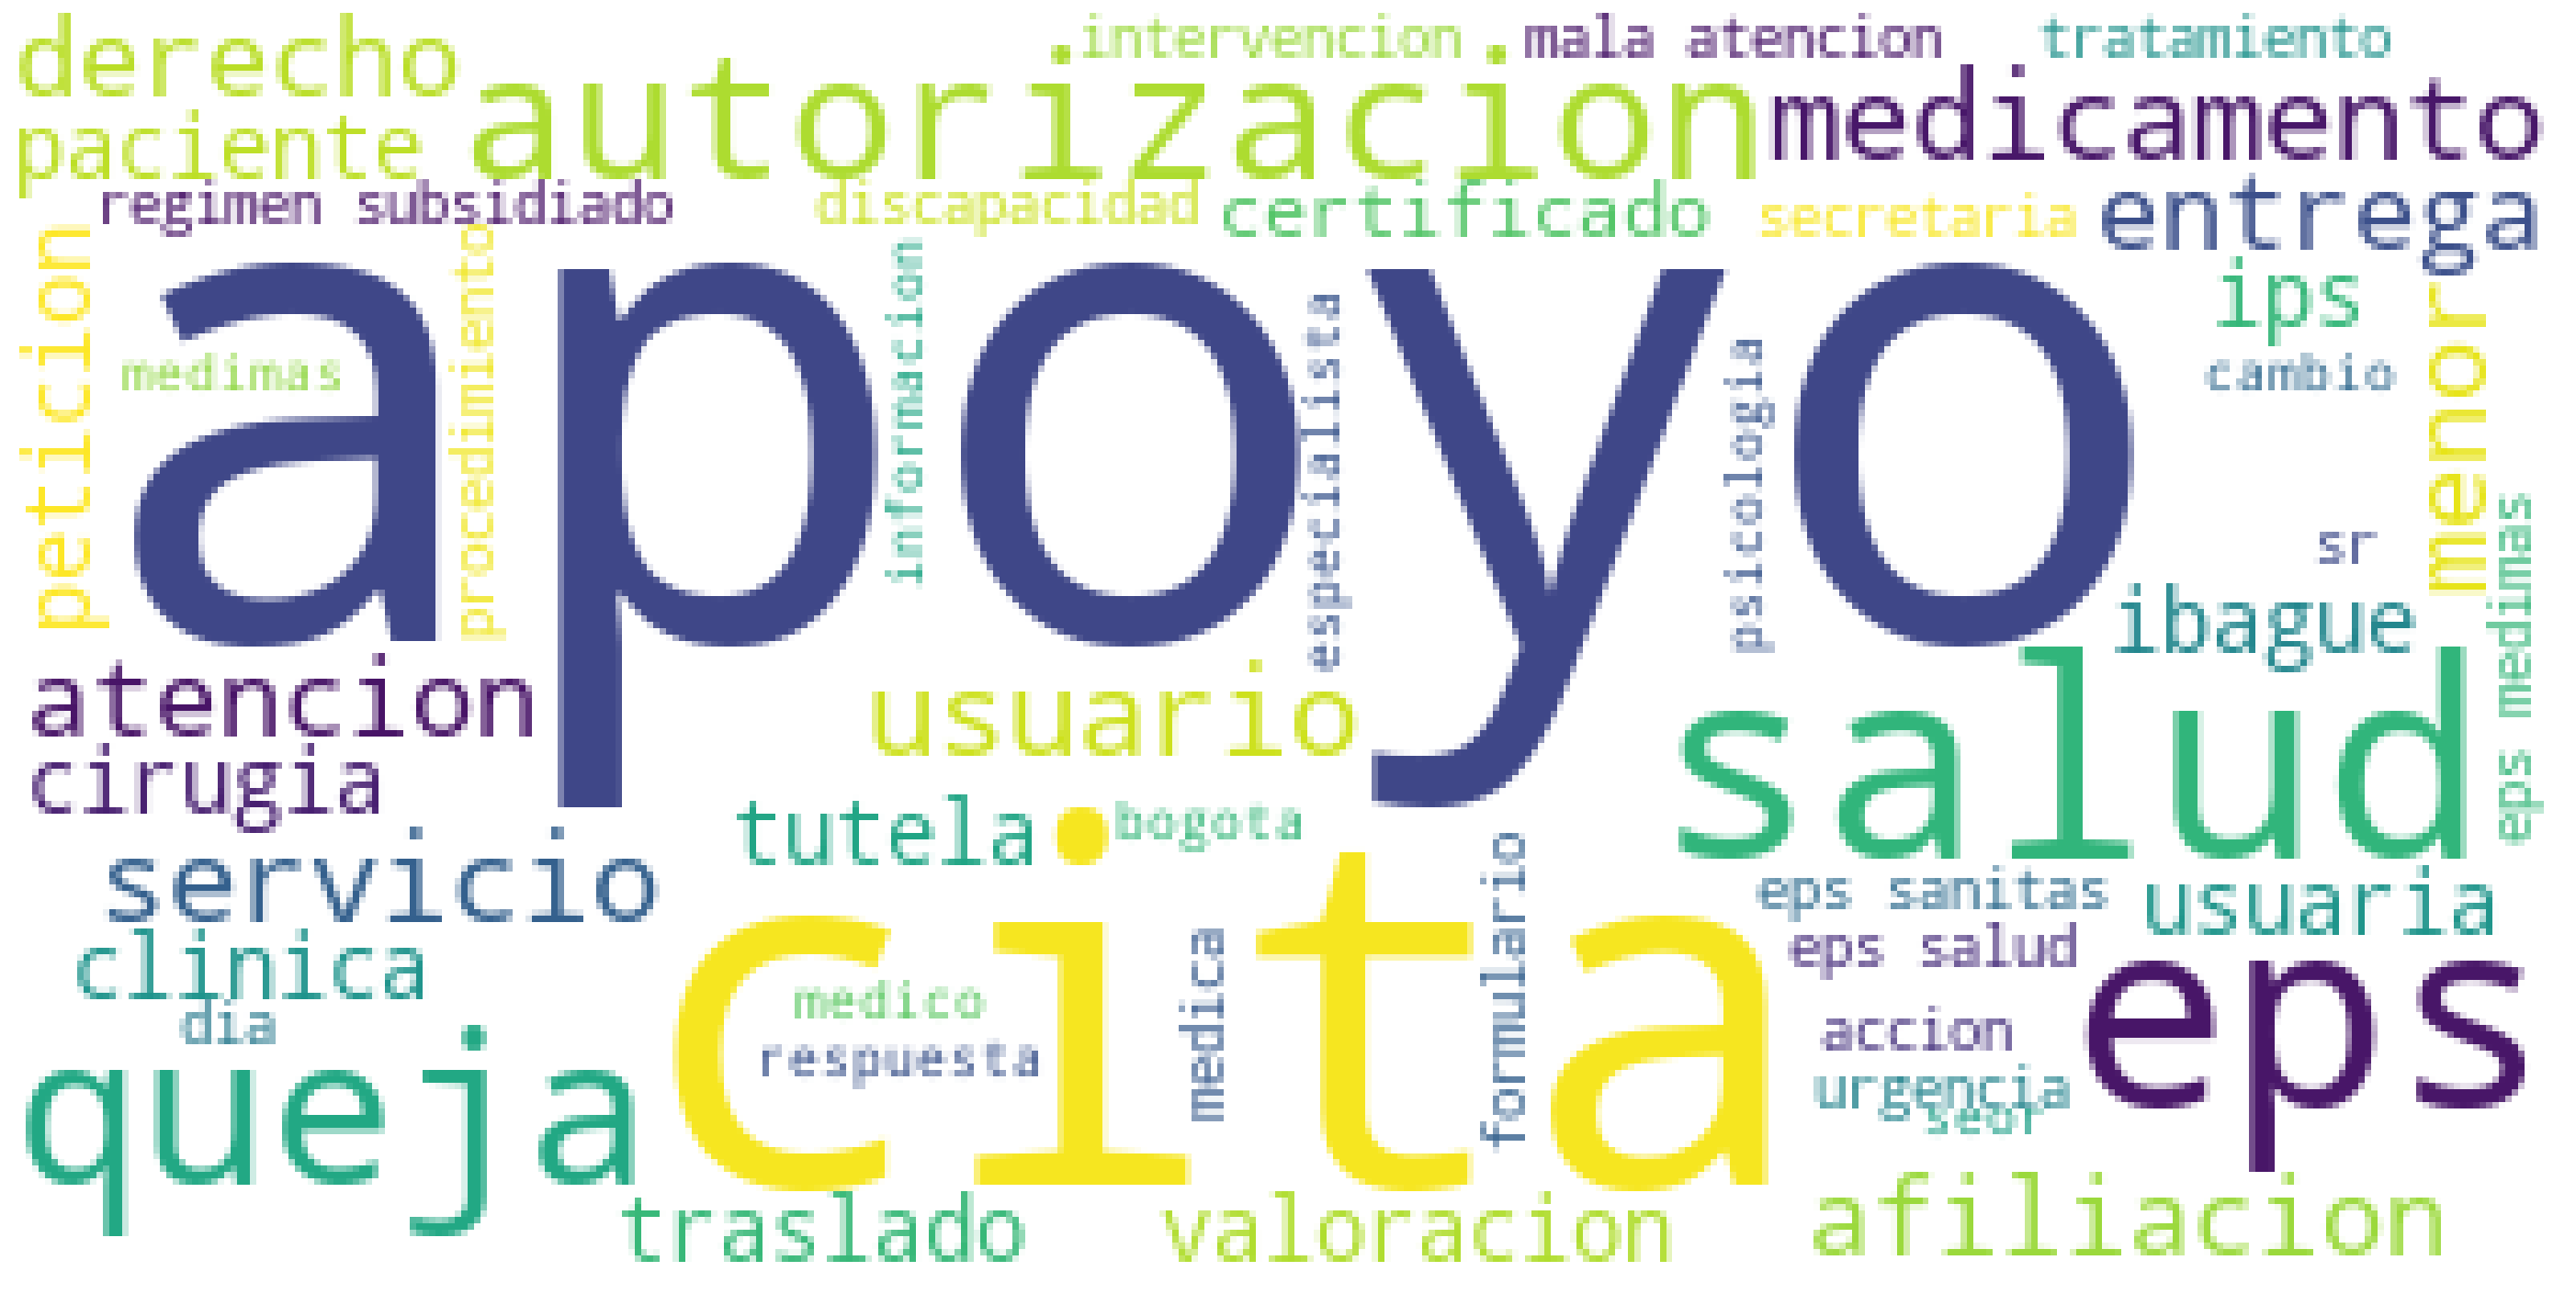

In [172]:
#loading list with stopwords in Spanish
stop = pd.read_csv(r"C:\Users\MarleneSarabia\Desktop\Universidad del Norte\DS4A\Conjuntos de datos\stop_words_spanish.txt", header = None, names = ["words"])
stop = stop["words"].values.tolist()

#Creating Wordcloud
cloud = WordCloud(background_color = "white", stopwords = stop, max_words = 50).generate(" ".join(df["asunto"]))

plt.figure(figsize = (50,50))
plt.imshow(cloud)
plt.axis("off")
plt.show()

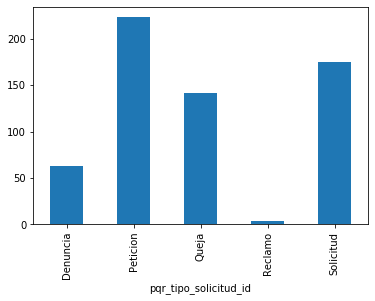

In [173]:
# Creating a barplot to see the distribution of the different categories
df["pqr_tipo_solicitud_id"].reset_index().groupby("pqr_tipo_solicitud_id").count().plot(kind = "bar", legend = False)

It is possible to see that there is an imbalance in the categories, so, we decide to group the minority categories i.e. Denuncia, Queja and Reclamo into one. This way it is possible to make the distribution less skewed.

In [174]:
cat_tra = {"Denuncia":"QRD", "Queja":"QRD", "Reclamo":"QRD"}
df["pqr_tipo_solicitud_id"] = df["pqr_tipo_solicitud_id"].replace(cat_tra)

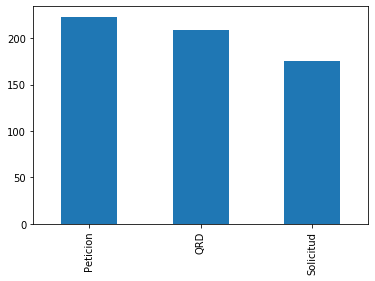

In [176]:
df["pqr_tipo_solicitud_id"].value_counts().plot(kind = "bar", legend = False)

# Data Modeling

In [180]:
#Split into test and training set
df_train =  df.sample(frac = 0.9, random_state = 10)
df_test = df.drop(df_train.index)

Multinomial Naive Bayes

In [181]:
#Vectorizing the variable asunto
vect = TfidfVectorizer(stop_words = stop, max_df = 0.8, min_df = 3, ngram_range = (1,2))
V = vect.fit_transform(df_train["asunto"])
column = vect.get_feature_names()
df_vect = pd.DataFrame(data = V.toarray(), columns = column)
df_vect.head(10)

,acceso,accion,accion tutela,accionada,accionado,accionante,actualizacion,acudiente,acuerdo,adelantar,...,valoracion psicologia,varon,vida,viene,villa,vinculacion,visita,visita inspeccion,vivienda,vivienda ubicada
0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.361122,0.0,0.289201,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [182]:
# Fitting the model
model = MultinomialNB()
model.fit(V, df_train["pqr_tipo_solicitud_id"])

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

Text(0.5, 1, 'Confusion Matrix Training Set')

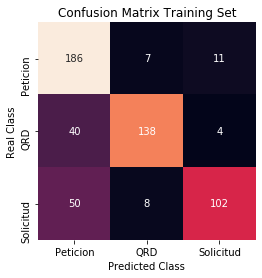

In [229]:
# Confusion matrix for fitted data
prediction_train = model.predict(V)
confusion_train = confusion_matrix(df_train["pqr_tipo_solicitud_id"],prediction_train)

sns.heatmap(confusion_train,square = True, annot = True, fmt = "d", cbar = False, xticklabels = ["Peticion", "QRD", "Solicitud"],
           yticklabels = ["Peticion", "QRD", "Solicitud"])
plt.xlabel("Predicted Class")
plt.ylabel("Real Class")
plt.title("Confusion Matrix Training Set")

In [223]:
# We find the AUC for the fitted data
prob_train = model.predict_proba(V)
print(roc_auc_score(df_train["pqr_tipo_solicitud_id"],prob_train, multi_class = "ovr"))


0.918053621107115


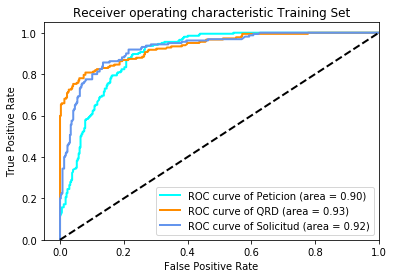

In [228]:
y_train = label_binarize(df_train["pqr_tipo_solicitud_id"], classes = ["Peticion", "QRD", "Solicitud"])

tpr = dict()
fpr = dict()
roc_auc = dict()

for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_train[:,i],prob_train[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()

colors = cycle(["aqua", "darkorange", "cornflowerblue"])
names = ["Peticion", "QRD", "Solicitud"]
for i, color in zip(range(3), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=2,
        label="ROC curve of {0} (area = {1:0.2f})".format(names[i], roc_auc[i]),
    )
plt.plot([0, 1], [0, 1], "k--", lw=2)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic Training Set")
plt.legend(loc="lower right")
plt.show()

In [230]:
#  Find the measures:
print(classification_report(df_train["pqr_tipo_solicitud_id"],prediction_train))

              precision    recall  f1-score   support

    Peticion       0.67      0.91      0.78       204
         QRD       0.90      0.76      0.82       182
   Solicitud       0.87      0.64      0.74       160

    accuracy                           0.78       546
   macro avg       0.82      0.77      0.78       546
weighted avg       0.81      0.78      0.78       546



In [186]:
# Predicting with the trainned model
vtest = vect.transform(df_test["asunto"])
prediction = model.predict(vtest)

Text(0.5, 1, 'Confusion Matrix Test Set')

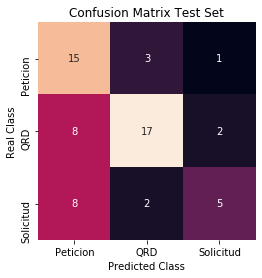

In [231]:
confusion = confusion_matrix(df_test["pqr_tipo_solicitud_id"],prediction)

sns.heatmap(confusion, square = True, annot = True, fmt = "d", cbar = False, xticklabels = ["Peticion", "QRD", "Solicitud"],
           yticklabels = ["Peticion", "QRD", "Solicitud"])

plt.xlabel("Predicted Class")
plt.ylabel("Real Class")
plt.title("Confusion Matrix Test Set")

In [188]:
# We find the AUC for the test set
prob_test = model.predict_proba(vtest)
roc_auc_score(df_test["pqr_tipo_solicitud_id"],prob_test, multi_class = "ovr")

0.7605328325075263

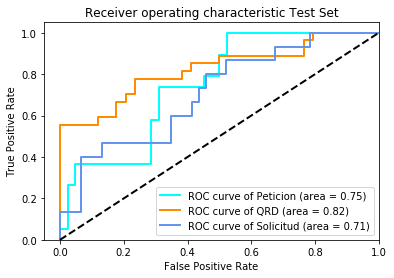

In [227]:
y_test = label_binarize(df_test["pqr_tipo_solicitud_id"], classes = ["Peticion", "QRD", "Solicitud"])

tpr_t = dict()
fpr_t = dict()
roc_auc_t = dict()

for i in range(3):
    fpr_t[i], tpr_t[i], _ = roc_curve(y_test[:,i],prob_test[:,i])
    roc_auc_t[i] = auc(fpr_t[i], tpr_t[i])

plt.figure()

colors = cycle(["aqua", "darkorange", "cornflowerblue"])
names = ["Peticion", "QRD", "Solicitud"]
for i, color in zip(range(3), colors):
    plt.plot(
        fpr_t[i],
        tpr_t[i],
        color=color,
        lw=2,
        label="ROC curve of {0} (area = {1:0.2f})".format(names[i], roc_auc_t[i]),
    )
plt.plot([0, 1], [0, 1], "k--", lw=2)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic Test Set")
plt.legend(loc="lower right")
plt.show()

In [189]:
# Find the measures:
print(classification_report(df_test["pqr_tipo_solicitud_id"],prediction))

              precision    recall  f1-score   support

    Peticion       0.48      0.79      0.60        19
         QRD       0.77      0.63      0.69        27
   Solicitud       0.62      0.33      0.43        15

    accuracy                           0.61        61
   macro avg       0.63      0.58      0.58        61
weighted avg       0.65      0.61      0.60        61



In [201]:
def predict_request_kind(s, model = model, vectorizer = vect):
    s = [re.sub('[^\w\s]','',unidecode.unidecode(s)).lower()]
    return print(model.predict(vect.transform(s)))
    

In [205]:
predict_request_kind("mal servicio")

['QRD']
